In [16]:
pip show pandas

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate
import re
import sqlite3

# URL 設定
url = "https://en.wikipedia.org/wiki/Travel_and_Tourism_Development_Index"

# User-Agent 設定
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# データリクエスト
response = requests.get(url, headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")

    # "2023 ranking" セクションの最初の <ol> タグを探す
    ranking_section = soup.find("ol")

    if ranking_section:
        # データ保存用リスト
        data = []

        # ランク、国名、スコアを抽出
        for rank, li in enumerate(ranking_section.find_all("li"), start=1):
            try:
                # 国名を <a> タグから抽出
                country = li.find("a").get_text(strip=True)

                # スコアを <li> タグのテキストから数値部分を抽出
                full_text = li.get_text(strip=True)
                score = re.search(r"(\d+\.\d+)$", full_text).group(1)  # スコアを正規表現で抽出

                # データをリストに保存
                data.append({"Rank": rank, "Country": country, "Score": float(score)})
            except AttributeError:
                print(f"データが不足しているためスキップ: {li}")

        # DataFrame を作成
        df = pd.DataFrame(data)

        # 表を出力
        print("\n== 2023年 旅行・観光開発指数 ==")
        print(tabulate(df, headers="keys", tablefmt="grid"))

        # CSV ファイルに保存
        csv_filename = "ttdi_2023.csv"
        df.to_csv(csv_filename, index=False, encoding="utf-8")
        print(f"\nデータが '{csv_filename}' ファイルに保存されました。")

        # SQLite データベースに保存
        db_filename = "ttdi_2023.db"
        conn = sqlite3.connect(db_filename)

        # テーブルを作成
        table_name = "ttdi_2023_ranking"
        create_table_query = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            Rank INTEGER PRIMARY KEY,
            Country TEXT NOT NULL,
            Score REAL NOT NULL
        );
        """
        conn.execute(create_table_query)

        # DataFrame のデータを SQLite に保存
        df.to_sql(table_name, conn, if_exists="replace", index=False)

        # データベース接続を閉じる
        conn.close()
        print(f"データが '{db_filename}' ファイルに保存されました。")
    else:
        print("2023 ranking セクションが見つかりませんでした。")
else:
    print(f"データ取得に失敗しました。HTTP ステータスコード: {response.status_code}")



== 2023年 旅行・観光開発指数 ==
+----+--------+----------------------+---------+
|    |   Rank | Country              |   Score |
+====+========+======================+=========+
|  0 |      1 | USA                  |    5.24 |
+----+--------+----------------------+---------+
|  1 |      2 | Spain                |    5.18 |
+----+--------+----------------------+---------+
|  2 |      3 | Japan                |    5.09 |
+----+--------+----------------------+---------+
|  3 |      4 | France               |    5.07 |
+----+--------+----------------------+---------+
|  4 |      5 | Australia            |    5    |
+----+--------+----------------------+---------+
|  5 |      6 | Germany              |    5    |
+----+--------+----------------------+---------+
|  6 |      7 | United Kingdom       |    4.96 |
+----+--------+----------------------+---------+
|  7 |      8 | China                |    4.94 |
+----+--------+----------------------+---------+
|  8 |      9 | Italy                |    4.9 

   Rank    Country  Score
0     1        USA   5.24
1     2      Spain   5.18
2     3      Japan   5.09
3     4     France   5.07
4     5  Australia   5.00
T-Statistic: 0.97, P-Value: 0.3956
結論: ヨーロッパの国の平均スコアはアジアの国より有意に高くありません。


<ipython-input-1-c175bc0c5aea>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Continent'] = data_filtered['Country'].apply(


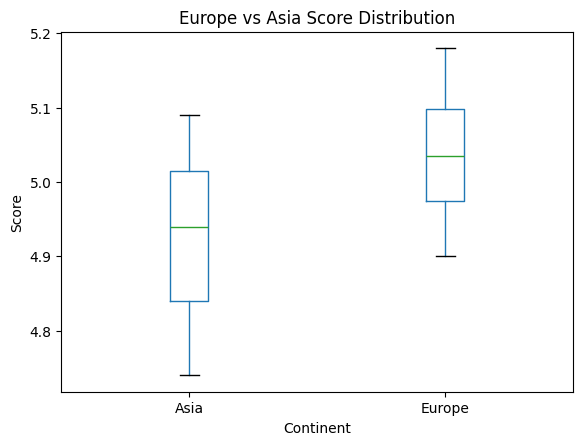

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Step 1: CSVファイルの読み込み
try:
    file_path = "ttdi_2023.csv"  # ファイルパス
    data = pd.read_csv(file_path)  # CSVファイルを読み込む
    print(data.head())  # データの確認
except Exception as e:
    print("CSVファイルの読み込み中にエラーが発生しました:", e)
    exit()

# Step 2: ヨーロッパとアジアの国リストを定義
europe_countries = ['France', 'Germany', 'Italy', 'Spain']  # ヨーロッパの国
asia_countries = ['Japan', 'China', 'India', 'South Korea']  # アジアの国

# Step 3: データのフィルタリング
# ヨーロッパの国のスコアを抽出
europe_data = data[data['Country'].isin(europe_countries)]['Score']
# アジアの国のスコアを抽出
asia_data = data[data['Country'].isin(asia_countries)]['Score']

# Step 4: t検定を実行
if len(europe_data) > 0 and len(asia_data) > 0:
    # ヨーロッパとアジアのスコアに基づいてt検定を実行
    t_stat, p_val = ttest_ind(europe_data, asia_data, equal_var=False)
    print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_val:.4f}")

    # p値に基づく結果の解釈
    if p_val < 0.05:
        print("結論: ヨーロッパの国の平均スコアはアジアの国より有意に高いです。")
    else:
        print("結論: ヨーロッパの国の平均スコアはアジアの国より有意に高くありません。")
else:
    print("ヨーロッパまたはアジアのデータが不足しています。")
    exit()

# Step 5: 可視化
# ヨーロッパとアジアの国をフィルタリングしたデータを作成
data_filtered = data[data['Country'].isin(europe_countries + asia_countries)]
# 大陸列を追加 (ヨーロッパかアジアかを判別)
data_filtered['Continent'] = data_filtered['Country'].apply(
    lambda x: 'Europe' if x in europe_countries else 'Asia'
)
# 箱ひげ図を作成
data_filtered.boxplot(column='Score', by='Continent', grid=False)
plt.title("Europe vs Asia Score Distribution")  # グラフのタイトル
plt.suptitle("")  # デフォルトのタイトルを削除
plt.xlabel("Continent")  # x軸ラベル
plt.ylabel("Score")  # y軸ラベル
plt.show()
